In [1]:
import pandas as pd
import numpy as np
import feather
import datetime
import talib
import mysql.connector
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras
from tensorflow import set_random_seed
from keras.optimizers import SGD
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import load_model
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.
C:\Users\Rugan\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Rugan\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Rugan\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
seed(1)
set_random_seed(2)

In [3]:
#DB connection string
config = {
        'user':'root',
        'password':'root',
        'host':'localhost',
        'database':'nsedb'        
        }

In [4]:
#Query
sql_select = "select concat(b.date,' ',b.time) as date, b.open,b.high,b.low,b.close from symbolmaster a left join indexProd b on a.id = b.symbol_id where a.symbol = %s and date >= %s and date <= %s order by date asc"

In [5]:
def getData(symbol,start,end):   
    try:
        conn = mysql.connector.connect(**config)
        c = conn.cursor(buffered=True)
        c.execute(sql_select, [symbol, start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d')])
        data = pd.DataFrame(c.fetchall())
        data.columns = c.column_names
        data.date = pd.to_datetime(data.date)
        data.set_index(['date'], inplace=True)
        c.close()
        conn.close()
        return data
    except mysql.connector.Error as err:
            print("DB Error: " + str(err))
            c.close()
            conn.close()

In [6]:
def balanceData(X,y):
    sm = SMOTE(random_state=2)
    X, y = sm.fit_sample(X, y)    
    return pd.DataFrame(X),pd.Series(y)

In [7]:
end = datetime.datetime.today()
start = datetime.datetime(year=2018,month=1,day=1)
symbol = 'BANKNIFTY'
#Text formatting
boldTextStart = "\033[1m"
boldTextEnd = "\033[0;0m"

In [8]:
dataset = getData(symbol,start,end)
data = dataset.copy()
data.shape

(160180, 4)

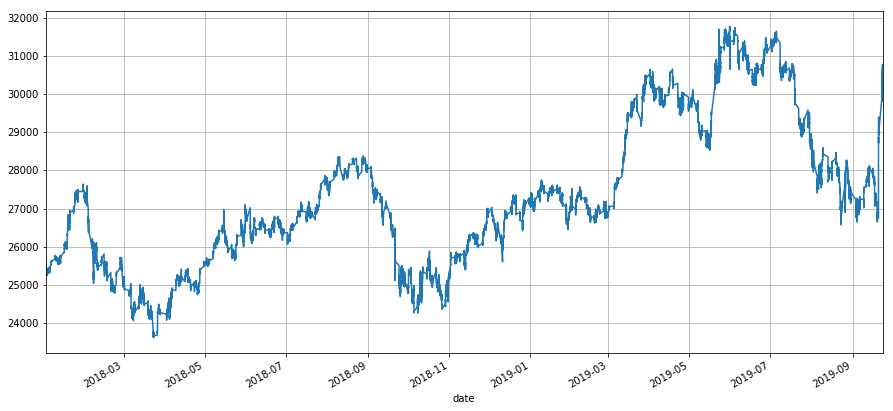

In [9]:
data['close'].plot(figsize=(15,7))
plt.grid()
plt.show()

In [10]:
initial_balance1 = data.between_time(start_time = '09:16:00', end_time = '10:15:00', include_end = True)
initial_balance2 = data.between_time(start_time = '14:31:00', end_time = '15:30:00', include_end = True)
initial_balance = pd.concat([initial_balance1,initial_balance2],axis=0)

In [11]:
initial_balance.dropna(inplace=True)

In [12]:
initial_balance.head()

,open,high,low,close
date,,,,
2018-01-01 09:16:00,25566.4,25566.4,25496.6,25535.8
2018-01-01 09:17:00,25534.2,25547.0,25524.8,25531.7
2018-01-01 09:18:00,25534.8,25551.9,25534.3,25544.3
2018-01-01 09:19:00,25543.7,25543.7,25524.9,25532.6
2018-01-01 09:20:00,25532.6,25542.9,25529.6,25539.3


In [13]:
eod_returns = data.between_time(start_time = '09:16:00', end_time = '15:30:00', include_end = True)

In [14]:
conversion = {'open' : 'first', 'high' : 'max', 'low' : 'min', 'close' : 'last'}
data2 = eod_returns.resample('1D', how = conversion)
data2['target'] = data2['open']/data2['close'].shift(1)
data2.dropna(inplace=True)

C:\Users\Rugan\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  from ipykernel import kernelapp as app


In [15]:
data2.head()

,low,open,close,high,target
date,,,,,
2018-01-02,25232.8,25387.0,25319.5,25425.5,1.004566
2018-01-03,25300.9,25433.2,25326.2,25454.9,1.004491
2018-01-04,25310.3,25356.1,25478.4,25490.3,1.001181
2018-01-05,25499.6,25510.2,25619.9,25643.3,1.001248
2018-01-09,25617.3,25737.4,25688.0,25803.8,1.002626


In [16]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [17]:
X = []
y = []
for single_date in daterange(start, end+timedelta(1)):
    if single_date.strftime("%Y-%m-%d") in data2.index:
        curr = single_date.strftime("%Y-%m-%d")
        
        Xdelta = []
        for i in range(0,initial_balance.loc[curr].shape[0]):
            
            for j in range(0,4):
                Xdelta.append(initial_balance.loc[curr].iloc[i][j])
        print(curr,' ',len(Xdelta))
        if(len(Xdelta) == 480):
            X.append(Xdelta)
            y.append(data2.loc[curr].loc['target'])
        else:
            print('Excluded - ',curr,' Length: ',len(Xdelta))

2018-01-02   480
2018-01-03   480
2018-01-04   480
2018-01-05   480
2018-01-09   480
2018-01-10   480
2018-01-11   480
2018-01-12   480
2018-01-16   480
2018-01-17   480
2018-01-18   480
2018-01-19   480
2018-01-23   480
2018-01-24   480
2018-01-25   480
2018-01-30   480
2018-01-31   480
2018-02-01   480
2018-02-02   480
2018-02-06   480
2018-02-07   480
2018-02-08   480
2018-02-09   480
2018-02-15   480
2018-02-16   480
2018-02-20   480
2018-02-21   480
2018-02-22   480
2018-02-23   480
2018-02-27   480
2018-02-28   480
2018-03-01   480
2018-03-06   480
2018-03-07   480
2018-03-08   480
2018-03-09   480
2018-03-13   480
2018-03-14   480
2018-03-15   480
2018-03-16   480
2018-03-20   480
2018-03-21   480
2018-03-22   480
2018-03-23   480
2018-03-27   480
2018-03-28   480
2018-04-03   480
2018-04-04   480
2018-04-05   480
2018-04-06   480
2018-04-10   480
2018-04-11   480
2018-04-12   480
2018-04-13   480
2018-04-17   480
2018-04-18   480
2018-04-19   480
2018-04-20   480
2018-04-24   4

In [18]:
print('Dimension of X:',len(X),'x',len(X[0]))
print('Dimension of y:',len(y))

Dimension of X: 316 x 480
Dimension of y: 316


In [19]:
cols = []
for i in range(0,120):
    for j in range(0,4):
        cols.append('f'+str(i)+str(j))
len(cols)

480

In [20]:
y = pd.Series(y)
X = pd.DataFrame(np.reshape(X,(y.shape[0],len(cols))), columns=cols)

In [21]:
target = pd.DataFrame()
target['Close'] = y

In [22]:
target.shape

(316, 1)

In [23]:
target['dir'] = 0
target['dir'] = np.where(target['Close'] > 1, 1, 0)

In [24]:
y = pd.Series(target['dir'])
y.shape

(316,)

In [25]:
X_y = pd.concat([X, y], axis=1)

In [26]:
X_y.dropna(inplace=True)
X = X_y.iloc[:,:-1]
y = X_y.iloc[:,-1]

In [28]:
print(sum(y == 0))
print(sum(y == 1))

108
208


In [29]:
X_balanced,y_balanced = balanceData(X,y)
print(sum(y_balanced == 0))
print(sum(y_balanced == 1))

208
208


In [30]:
print('Dimension of X:',X.shape)
print('Dimension of y:',len(y))

Dimension of X: (316, 480)
Dimension of y: 316


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced,y_balanced, test_size=0.2, shuffle=True)

In [32]:
print(X_train.shape)
print(X_test.shape)

(332, 480)
(84, 480)


In [33]:
print(sum(y_train == 0))
print(sum(y_train == 1))
print(sum(y_test == 0))
print(sum(y_test == 1))

167
165
41
43


In [34]:
# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
unit = 1024
optimizer = SGD(lr=0.001, momentum=0.0, nesterov=True)
kernel_init = 'he_uniform'
activation = 'relu'   
checkpoint = keras.callbacks.ModelCheckpoint('bestmodel.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')
stoppoint = keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=0, patience=200)
classifier = Sequential()
classifier.add(Dense(units = 512, kernel_initializer = kernel_init, activation = activation,input_dim = X_train_scaled.shape[1]))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit//2, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = 1, kernel_initializer = kernel_init, activation = 'sigmoid'))
classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(X_train_scaled, y_train, batch_size = 50, epochs = 1000, 
               validation_split = 0.3 , callbacks=[checkpoint, stoppoint],verbose=1)

Train on 232 samples, validate on 100 samples
Epoch 1/1000
232/232 [==============================] - 1s 4ms/step - loss: 0.7040 - acc: 0.4957 - val_loss: 0.6806 - val_acc: 0.6300

Epoch 00001: val_acc improved from -inf to 0.63000, saving model to bestmodel.h5
Epoch 2/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.7001 - acc: 0.4914 - val_loss: 0.6944 - val_acc: 0.5400

Epoch 00002: val_acc did not improve from 0.63000
Epoch 3/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.7079 - acc: 0.5345 - val_loss: 0.6828 - val_acc: 0.5800

Epoch 00003: val_acc did not improve from 0.63000
Epoch 4/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6994 - acc: 0.4698 - val_loss: 0.6869 - val_acc: 0.6100

Epoch 00004: val_acc did not improve from 0.63000
Epoch 5/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6875 - acc: 0.5517 - val_loss: 0.7580 - val_acc: 0.4700

Epoch 00005: val_acc did not improve from 0.6300


Epoch 00044: val_acc did not improve from 0.63000
Epoch 45/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6770 - acc: 0.5690 - val_loss: 0.8089 - val_acc: 0.4800

Epoch 00045: val_acc did not improve from 0.63000
Epoch 46/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6905 - acc: 0.5560 - val_loss: 0.7659 - val_acc: 0.5000

Epoch 00046: val_acc did not improve from 0.63000
Epoch 47/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6896 - acc: 0.5517 - val_loss: 0.7556 - val_acc: 0.4700

Epoch 00047: val_acc did not improve from 0.63000
Epoch 48/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6773 - acc: 0.6164 - val_loss: 0.6912 - val_acc: 0.5500

Epoch 00048: val_acc did not improve from 0.63000
Epoch 49/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6707 - acc: 0.5862 - val_loss: 0.6886 - val_acc: 0.5500

Epoch 00049: val_acc did not improve from 0.63000
Epoch 50/1000
232/2

232/232 [==============================] - 0s 2ms/step - loss: 0.6818 - acc: 0.6078 - val_loss: 0.7094 - val_acc: 0.5000

Epoch 00089: val_acc did not improve from 0.63000
Epoch 90/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6591 - acc: 0.6207 - val_loss: 0.6841 - val_acc: 0.5700

Epoch 00090: val_acc did not improve from 0.63000
Epoch 91/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6670 - acc: 0.6078 - val_loss: 0.6975 - val_acc: 0.5100

Epoch 00091: val_acc did not improve from 0.63000
Epoch 92/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6647 - acc: 0.5819 - val_loss: 0.6866 - val_acc: 0.5600

Epoch 00092: val_acc did not improve from 0.63000
Epoch 93/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6703 - acc: 0.6078 - val_loss: 0.6902 - val_acc: 0.5600

Epoch 00093: val_acc did not improve from 0.63000
Epoch 94/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6716 

232/232 [==============================] - 0s 2ms/step - loss: 0.6714 - acc: 0.6034 - val_loss: 0.6800 - val_acc: 0.5900

Epoch 00133: val_acc did not improve from 0.63000
Epoch 134/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6596 - acc: 0.6250 - val_loss: 0.7033 - val_acc: 0.5000

Epoch 00134: val_acc did not improve from 0.63000
Epoch 135/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6668 - acc: 0.5991 - val_loss: 0.7306 - val_acc: 0.4900

Epoch 00135: val_acc did not improve from 0.63000
Epoch 136/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6606 - acc: 0.6121 - val_loss: 0.7357 - val_acc: 0.5000

Epoch 00136: val_acc did not improve from 0.63000
Epoch 137/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6591 - acc: 0.5776 - val_loss: 0.7274 - val_acc: 0.5000

Epoch 00137: val_acc did not improve from 0.63000
Epoch 138/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.

232/232 [==============================] - 0s 2ms/step - loss: 0.6582 - acc: 0.6121 - val_loss: 0.7315 - val_acc: 0.4900

Epoch 00177: val_acc did not improve from 0.63000
Epoch 178/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6615 - acc: 0.6121 - val_loss: 0.7217 - val_acc: 0.5000

Epoch 00178: val_acc did not improve from 0.63000
Epoch 179/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6544 - acc: 0.6422 - val_loss: 0.7044 - val_acc: 0.5100

Epoch 00179: val_acc did not improve from 0.63000
Epoch 180/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6513 - acc: 0.6293 - val_loss: 0.6967 - val_acc: 0.5900

Epoch 00180: val_acc did not improve from 0.63000
Epoch 181/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6726 - acc: 0.5862 - val_loss: 0.6915 - val_acc: 0.5800

Epoch 00181: val_acc did not improve from 0.63000
Epoch 182/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.

232/232 [==============================] - 0s 2ms/step - loss: 0.6514 - acc: 0.6293 - val_loss: 0.7546 - val_acc: 0.5100

Epoch 00221: val_acc did not improve from 0.63000
Epoch 222/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6642 - acc: 0.6336 - val_loss: 0.6904 - val_acc: 0.5700

Epoch 00222: val_acc did not improve from 0.63000
Epoch 223/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6490 - acc: 0.6379 - val_loss: 0.6833 - val_acc: 0.5900

Epoch 00223: val_acc did not improve from 0.63000
Epoch 224/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6615 - acc: 0.6121 - val_loss: 0.6885 - val_acc: 0.5800

Epoch 00224: val_acc did not improve from 0.63000
Epoch 225/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6649 - acc: 0.6293 - val_loss: 0.7118 - val_acc: 0.5400

Epoch 00225: val_acc did not improve from 0.63000
Epoch 226/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.

232/232 [==============================] - 0s 2ms/step - loss: 0.6544 - acc: 0.6078 - val_loss: 0.7205 - val_acc: 0.5200

Epoch 00265: val_acc did not improve from 0.63000
Epoch 266/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6659 - acc: 0.6164 - val_loss: 0.6754 - val_acc: 0.5900

Epoch 00266: val_acc did not improve from 0.63000
Epoch 267/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6535 - acc: 0.6250 - val_loss: 0.7260 - val_acc: 0.5200

Epoch 00267: val_acc did not improve from 0.63000
Epoch 268/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6483 - acc: 0.6250 - val_loss: 0.7392 - val_acc: 0.5200

Epoch 00268: val_acc did not improve from 0.63000
Epoch 269/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6566 - acc: 0.6250 - val_loss: 0.7103 - val_acc: 0.5400

Epoch 00269: val_acc did not improve from 0.63000
Epoch 270/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.


Epoch 00308: val_acc did not improve from 0.63000
Epoch 309/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6479 - acc: 0.6509 - val_loss: 0.7509 - val_acc: 0.5300

Epoch 00309: val_acc did not improve from 0.63000
Epoch 310/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6457 - acc: 0.6164 - val_loss: 0.7049 - val_acc: 0.6100

Epoch 00310: val_acc did not improve from 0.63000
Epoch 311/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6485 - acc: 0.6250 - val_loss: 0.6807 - val_acc: 0.6000

Epoch 00311: val_acc did not improve from 0.63000
Epoch 312/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6507 - acc: 0.6336 - val_loss: 0.7237 - val_acc: 0.5300

Epoch 00312: val_acc did not improve from 0.63000
Epoch 313/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6454 - acc: 0.6509 - val_loss: 0.6797 - val_acc: 0.5800

Epoch 00313: val_acc did not improve from 0.63000
Epoch 314/1000


Epoch 00352: val_acc did not improve from 0.63000
Epoch 353/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6549 - acc: 0.6509 - val_loss: 0.6821 - val_acc: 0.5500

Epoch 00353: val_acc did not improve from 0.63000
Epoch 354/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6501 - acc: 0.6207 - val_loss: 0.6740 - val_acc: 0.6000

Epoch 00354: val_acc did not improve from 0.63000
Epoch 355/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6603 - acc: 0.5948 - val_loss: 0.7583 - val_acc: 0.5200

Epoch 00355: val_acc did not improve from 0.63000
Epoch 356/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6460 - acc: 0.6595 - val_loss: 0.6907 - val_acc: 0.5800

Epoch 00356: val_acc did not improve from 0.63000
Epoch 357/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6494 - acc: 0.5905 - val_loss: 0.7333 - val_acc: 0.5200

Epoch 00357: val_acc did not improve from 0.63000
Epoch 358/1000


Epoch 00396: val_acc did not improve from 0.63000
Epoch 397/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6418 - acc: 0.6466 - val_loss: 0.6840 - val_acc: 0.5800

Epoch 00397: val_acc did not improve from 0.63000
Epoch 398/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6407 - acc: 0.6853 - val_loss: 0.6752 - val_acc: 0.5800

Epoch 00398: val_acc did not improve from 0.63000
Epoch 399/1000
232/232 [==============================] - ETA: 0s - loss: 0.6524 - acc: 0.635 - 0s 2ms/step - loss: 0.6639 - acc: 0.6164 - val_loss: 0.7597 - val_acc: 0.5300

Epoch 00399: val_acc did not improve from 0.63000
Epoch 400/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6494 - acc: 0.6379 - val_loss: 0.7250 - val_acc: 0.5100

Epoch 00400: val_acc did not improve from 0.63000
Epoch 401/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6459 - acc: 0.6250 - val_loss: 0.6738 - val_acc: 0.5900

Epoch 00401: val_acc did n

232/232 [==============================] - ETA: 0s - loss: 0.6433 - acc: 0.650 - 0s 2ms/step - loss: 0.6380 - acc: 0.6509 - val_loss: 0.7171 - val_acc: 0.5100

Epoch 00440: val_acc did not improve from 0.63000
Epoch 441/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6588 - acc: 0.6164 - val_loss: 0.7288 - val_acc: 0.5000

Epoch 00441: val_acc did not improve from 0.63000
Epoch 442/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6348 - acc: 0.6724 - val_loss: 0.6737 - val_acc: 0.6000

Epoch 00442: val_acc did not improve from 0.63000
Epoch 443/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6438 - acc: 0.6121 - val_loss: 0.6925 - val_acc: 0.5600

Epoch 00443: val_acc did not improve from 0.63000
Epoch 444/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6369 - acc: 0.6466 - val_loss: 0.7101 - val_acc: 0.5100

Epoch 00444: val_acc did not improve from 0.63000
Epoch 445/1000
232/232 [==================

232/232 [==============================] - 0s 2ms/step - loss: 0.6331 - acc: 0.6250 - val_loss: 0.7110 - val_acc: 0.5700

Epoch 00483: val_acc did not improve from 0.63000
Epoch 484/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6345 - acc: 0.6638 - val_loss: 0.7385 - val_acc: 0.5200

Epoch 00484: val_acc did not improve from 0.63000
Epoch 485/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6546 - acc: 0.6164 - val_loss: 0.6977 - val_acc: 0.5600

Epoch 00485: val_acc did not improve from 0.63000
Epoch 486/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6367 - acc: 0.6724 - val_loss: 0.6795 - val_acc: 0.5700

Epoch 00486: val_acc did not improve from 0.63000
Epoch 487/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6427 - acc: 0.6379 - val_loss: 0.8131 - val_acc: 0.5100

Epoch 00487: val_acc did not improve from 0.63000
Epoch 488/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.

232/232 [==============================] - 0s 2ms/step - loss: 0.6522 - acc: 0.6336 - val_loss: 0.7279 - val_acc: 0.5300

Epoch 00527: val_acc did not improve from 0.63000
Epoch 528/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6397 - acc: 0.6379 - val_loss: 0.7155 - val_acc: 0.5300

Epoch 00528: val_acc did not improve from 0.63000
Epoch 529/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6271 - acc: 0.6767 - val_loss: 0.6855 - val_acc: 0.5600

Epoch 00529: val_acc did not improve from 0.63000
Epoch 530/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6359 - acc: 0.6336 - val_loss: 0.6954 - val_acc: 0.5500

Epoch 00530: val_acc did not improve from 0.63000
Epoch 531/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6374 - acc: 0.6509 - val_loss: 0.7147 - val_acc: 0.5600

Epoch 00531: val_acc did not improve from 0.63000
Epoch 532/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.


Epoch 00570: val_acc did not improve from 0.63000
Epoch 571/1000
232/232 [==============================] - 1s 2ms/step - loss: 0.6348 - acc: 0.6681 - val_loss: 0.7417 - val_acc: 0.5200

Epoch 00571: val_acc did not improve from 0.63000
Epoch 572/1000
232/232 [==============================] - 1s 2ms/step - loss: 0.6423 - acc: 0.6336 - val_loss: 0.6891 - val_acc: 0.5600

Epoch 00572: val_acc did not improve from 0.63000
Epoch 573/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.6494 - acc: 0.5905 - val_loss: 0.6761 - val_acc: 0.5700

Epoch 00573: val_acc did not improve from 0.63000
Epoch 574/1000
232/232 [==============================] - 1s 3ms/step - loss: 0.6290 - acc: 0.6509 - val_loss: 0.6695 - val_acc: 0.5900

Epoch 00574: val_acc did not improve from 0.63000
Epoch 575/1000
232/232 [==============================] - 1s 2ms/step - loss: 0.6311 - acc: 0.6250 - val_loss: 0.7264 - val_acc: 0.5300

Epoch 00575: val_acc did not improve from 0.63000
Epoch 576/1000

232/232 [==============================] - 0s 2ms/step - loss: 0.6251 - acc: 0.6552 - val_loss: 0.7025 - val_acc: 0.5400

Epoch 00614: val_acc did not improve from 0.63000
Epoch 615/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6280 - acc: 0.6466 - val_loss: 0.7852 - val_acc: 0.5100

Epoch 00615: val_acc did not improve from 0.63000
Epoch 616/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6344 - acc: 0.6681 - val_loss: 0.7359 - val_acc: 0.5100

Epoch 00616: val_acc did not improve from 0.63000
Epoch 617/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6419 - acc: 0.6293 - val_loss: 0.7160 - val_acc: 0.5000

Epoch 00617: val_acc did not improve from 0.63000
Epoch 618/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6389 - acc: 0.6336 - val_loss: 0.6993 - val_acc: 0.5400

Epoch 00618: val_acc did not improve from 0.63000
Epoch 619/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.

232/232 [==============================] - 0s 2ms/step - loss: 0.6333 - acc: 0.6422 - val_loss: 0.6763 - val_acc: 0.5900

Epoch 00658: val_acc did not improve from 0.63000
Epoch 659/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6281 - acc: 0.6250 - val_loss: 0.7363 - val_acc: 0.5300

Epoch 00659: val_acc did not improve from 0.63000
Epoch 660/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6315 - acc: 0.6379 - val_loss: 0.6717 - val_acc: 0.6100

Epoch 00660: val_acc did not improve from 0.63000
Epoch 661/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6265 - acc: 0.6422 - val_loss: 0.6791 - val_acc: 0.5500

Epoch 00661: val_acc did not improve from 0.63000
Epoch 662/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6280 - acc: 0.6595 - val_loss: 0.6798 - val_acc: 0.5900

Epoch 00662: val_acc did not improve from 0.63000
Epoch 663/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.

232/232 [==============================] - 0s 2ms/step - loss: 0.6377 - acc: 0.6250 - val_loss: 0.6771 - val_acc: 0.5900

Epoch 00702: val_acc did not improve from 0.63000
Epoch 703/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6248 - acc: 0.6681 - val_loss: 0.6718 - val_acc: 0.6100

Epoch 00703: val_acc did not improve from 0.63000
Epoch 704/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6207 - acc: 0.6681 - val_loss: 0.7148 - val_acc: 0.5600

Epoch 00704: val_acc did not improve from 0.63000
Epoch 705/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6568 - acc: 0.6724 - val_loss: 0.7102 - val_acc: 0.5500

Epoch 00705: val_acc did not improve from 0.63000
Epoch 706/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6305 - acc: 0.6681 - val_loss: 0.6926 - val_acc: 0.5600

Epoch 00706: val_acc did not improve from 0.63000
Epoch 707/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.

232/232 [==============================] - 0s 2ms/step - loss: 0.6454 - acc: 0.6422 - val_loss: 0.6744 - val_acc: 0.5800

Epoch 00746: val_acc did not improve from 0.63000
Epoch 747/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6184 - acc: 0.6552 - val_loss: 0.6864 - val_acc: 0.5600

Epoch 00747: val_acc did not improve from 0.63000
Epoch 748/1000
232/232 [==============================] - 1s 2ms/step - loss: 0.6529 - acc: 0.5819 - val_loss: 0.7551 - val_acc: 0.5200

Epoch 00748: val_acc did not improve from 0.63000
Epoch 749/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6310 - acc: 0.6422 - val_loss: 0.7021 - val_acc: 0.5900

Epoch 00749: val_acc did not improve from 0.63000
Epoch 750/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6158 - acc: 0.6595 - val_loss: 0.6816 - val_acc: 0.5700

Epoch 00750: val_acc did not improve from 0.63000
Epoch 751/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.


Epoch 00789: val_acc did not improve from 0.63000
Epoch 790/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6278 - acc: 0.6336 - val_loss: 0.6877 - val_acc: 0.5600

Epoch 00790: val_acc did not improve from 0.63000
Epoch 791/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6485 - acc: 0.6595 - val_loss: 0.6728 - val_acc: 0.5900

Epoch 00791: val_acc did not improve from 0.63000
Epoch 792/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6178 - acc: 0.6595 - val_loss: 0.7134 - val_acc: 0.5300

Epoch 00792: val_acc did not improve from 0.63000
Epoch 793/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6156 - acc: 0.6681 - val_loss: 0.7094 - val_acc: 0.5200

Epoch 00793: val_acc did not improve from 0.63000
Epoch 794/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6292 - acc: 0.6336 - val_loss: 0.6867 - val_acc: 0.5700

Epoch 00794: val_acc did not improve from 0.63000
Epoch 795/1000


Epoch 00833: val_acc did not improve from 0.63000
Epoch 834/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6435 - acc: 0.6293 - val_loss: 0.6680 - val_acc: 0.5800

Epoch 00834: val_acc did not improve from 0.63000
Epoch 835/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6175 - acc: 0.6983 - val_loss: 0.6826 - val_acc: 0.5900

Epoch 00835: val_acc did not improve from 0.63000
Epoch 836/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6315 - acc: 0.6509 - val_loss: 0.7122 - val_acc: 0.5300

Epoch 00836: val_acc did not improve from 0.63000
Epoch 837/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6150 - acc: 0.6638 - val_loss: 0.7252 - val_acc: 0.5000

Epoch 00837: val_acc did not improve from 0.63000
Epoch 838/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6473 - acc: 0.6250 - val_loss: 0.6653 - val_acc: 0.5900

Epoch 00838: val_acc did not improve from 0.63000
Epoch 839/1000


Epoch 00877: val_acc did not improve from 0.63000
Epoch 878/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6123 - acc: 0.6681 - val_loss: 0.8770 - val_acc: 0.5100

Epoch 00878: val_acc did not improve from 0.63000
Epoch 879/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6259 - acc: 0.6552 - val_loss: 0.6667 - val_acc: 0.5900

Epoch 00879: val_acc did not improve from 0.63000
Epoch 880/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6550 - acc: 0.6250 - val_loss: 0.7077 - val_acc: 0.5700

Epoch 00880: val_acc did not improve from 0.63000
Epoch 881/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6131 - acc: 0.6853 - val_loss: 0.6703 - val_acc: 0.5800

Epoch 00881: val_acc did not improve from 0.63000
Epoch 882/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6258 - acc: 0.6724 - val_loss: 0.6941 - val_acc: 0.5800

Epoch 00882: val_acc did not improve from 0.63000
Epoch 883/1000


Epoch 00921: val_acc did not improve from 0.63000
Epoch 922/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6173 - acc: 0.6595 - val_loss: 0.7320 - val_acc: 0.5400

Epoch 00922: val_acc did not improve from 0.63000
Epoch 923/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6301 - acc: 0.6250 - val_loss: 0.6792 - val_acc: 0.5600

Epoch 00923: val_acc did not improve from 0.63000
Epoch 924/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6099 - acc: 0.6853 - val_loss: 0.6708 - val_acc: 0.5800

Epoch 00924: val_acc did not improve from 0.63000
Epoch 925/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6187 - acc: 0.6509 - val_loss: 0.6759 - val_acc: 0.5700

Epoch 00925: val_acc did not improve from 0.63000
Epoch 926/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6136 - acc: 0.6379 - val_loss: 0.7370 - val_acc: 0.5000

Epoch 00926: val_acc did not improve from 0.63000
Epoch 927/1000


Epoch 00965: val_acc did not improve from 0.63000
Epoch 966/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6284 - acc: 0.6250 - val_loss: 0.6639 - val_acc: 0.5800

Epoch 00966: val_acc did not improve from 0.63000
Epoch 967/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6228 - acc: 0.6379 - val_loss: 0.6941 - val_acc: 0.5800

Epoch 00967: val_acc did not improve from 0.63000
Epoch 968/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6163 - acc: 0.6207 - val_loss: 0.6650 - val_acc: 0.5800

Epoch 00968: val_acc did not improve from 0.63000
Epoch 969/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6077 - acc: 0.7241 - val_loss: 0.6859 - val_acc: 0.5700

Epoch 00969: val_acc did not improve from 0.63000
Epoch 970/1000
232/232 [==============================] - 0s 2ms/step - loss: 0.6102 - acc: 0.6595 - val_loss: 0.6661 - val_acc: 0.5800

Epoch 00970: val_acc did not improve from 0.63000
Epoch 971/1000

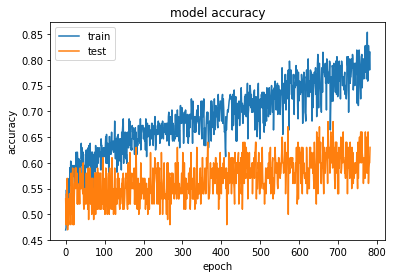

In [53]:
# summarize history for accuracy
plt.plot(classifier.history.history['acc'])
plt.plot(classifier.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

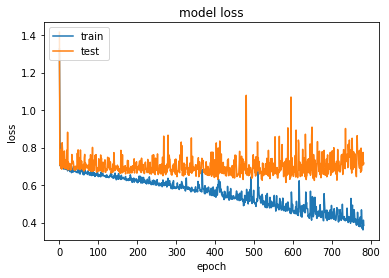

In [54]:
# summarize history for loss
plt.plot(classifier.history.history['loss'])
plt.plot(classifier.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
#model = load_model('./Saved Models/model360-2509-653.h5')
model = load_model('bestmodel.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               246272    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
__________

In [37]:
#Accuracy of test set
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5)
print(boldTextStart,'Accuracy:',boldTextEnd)
accuracy_model = accuracy_score(y_test, y_pred, normalize=True)*100
print(accuracy_model,' %')
print(boldTextStart,'Confusion Matrix:',boldTextEnd)
print(confusion_matrix(y_test,y_pred))
print(boldTextStart,'Classification Report:',boldTextEnd)
print(classification_report(y_test,y_pred))
auc = roc_auc_score(y_test,y_pred)
print(boldTextStart,'AUC Score: ',boldTextEnd, auc)

 Accuracy: 
60.71428571428571  %
 Confusion Matrix: 
[[14 27]
 [ 6 37]]
 Classification Report: 
              precision    recall  f1-score   support

           0       0.70      0.34      0.46        41
           1       0.58      0.86      0.69        43

   micro avg       0.61      0.61      0.61        84
   macro avg       0.64      0.60      0.58        84
weighted avg       0.64      0.61      0.58        84

 AUC Score:   0.6009642654566081
